<a href="https://colab.research.google.com/github/Saldor11/ModeloGenerativoICA/blob/main/SegmentadorUnetMultiTask_16INIDLossAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
!pip install scikit-image

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import hausdorff_distance
import PIL
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchmetrics.segmentation import GeneralizedDiceScore, MeanIoU
import torchvision.utils as vutils
from torchsummary import summary
#from torchcontrib.optim import SWA
from UnetMultiTaskModOriginalAttention import MultiTaskUNET
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Rutas de datos
TRAIN_PATH = '/content/drive/MyDrive/data/ICA_PNG'
TRAIN_MASK_PATH = '/content/drive/MyDrive/data/label'
TRAIN_SKELETON_PATH = '/content/drive/MyDrive/data/Esqueletos'
save_path = '/content/drive/MyDrive/Multitask/Modelos'
save_path1 = '/content/drive/MyDrive/Multitask/PredSeg'
save_path2 = '/content/drive/MyDrive/Multitask/PredSkel'
save_path3 = '/content/drive/MyDrive/Multitask/PredSegTest'
save_path4 = '/content/drive/MyDrive/Multitask/PredSkelTest'

files = os.listdir(TRAIN_PATH)
files1 = os.listdir(TRAIN_MASK_PATH)
files2 = os.listdir(TRAIN_SKELETON_PATH)

# Contar la cantidad de archivos
num_files = len(files)
num_files1 = len(files1)
num_files2 = len(files2)

print(f"Cantidad de archivos en la carpeta: {num_files}, {num_files1} Y {num_files2}")

Cantidad de archivos en la carpeta: 616, 616 Y 616


In [ ]:
model = MultiTaskUNET()

In [ ]:
# Fijar la semilla para reproducibilidad
Valseed = 70
torch.manual_seed(Valseed)
random.seed(Valseed)
np.random.seed(Valseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Valseed)

In [ ]:
# Clase personalizada del Dataset
class DatasetIm(Dataset):
    def __init__(self, data_path, mask_path, skel_path, transform=None):
        self.images = sorted(os.listdir(data_path))
        self.masks = sorted(os.listdir(mask_path)) if mask_path else None
        self.skeletons = sorted(os.listdir(skel_path)) if skel_path else None
        self.data_path = data_path
        self.mask_path = mask_path
        self.skel_path = skel_path
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Cargar imagen
        img = Image.open(os.path.join(self.data_path, self.images[idx])).convert('L')
        mask = Image.open(os.path.join(self.mask_path, self.masks[idx])).convert('L')
        skel = Image.open(os.path.join(self.skel_path, self.skeletons[idx])).convert('L')

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
            skel = self.transform(skel)

        return img, mask, skel

In [ ]:
# Transformaciones para las imágenes y las máscaras
transform = T.Compose([
    T.ToTensor(),  # Convertir a tensor
])

In [ ]:
# Parámetros de entrenamiento
batch_size = 4
epochs = 150
l_rate = 1e-2

In [ ]:
# Cargar dataset completo
dataset = DatasetIm(TRAIN_PATH, TRAIN_MASK_PATH, TRAIN_SKELETON_PATH, transform=transform)

# Dividir en entrenamiento, validación y prueba
train_size = int(0.6 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Train dataset: {len(train_dataset)}\nValidation dataset: {len(val_dataset)}\nTest dataset: {len(test_dataset)}\n')

Train dataset: 369
Validation dataset: 61
Test dataset: 186



In [ ]:
# Cargar datos con DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Image shape: torch.Size([4, 1, 512, 512])
Mask shape: torch.Size([4, 1, 512, 512])
Skel shape: torch.Size([4, 1, 512, 512])



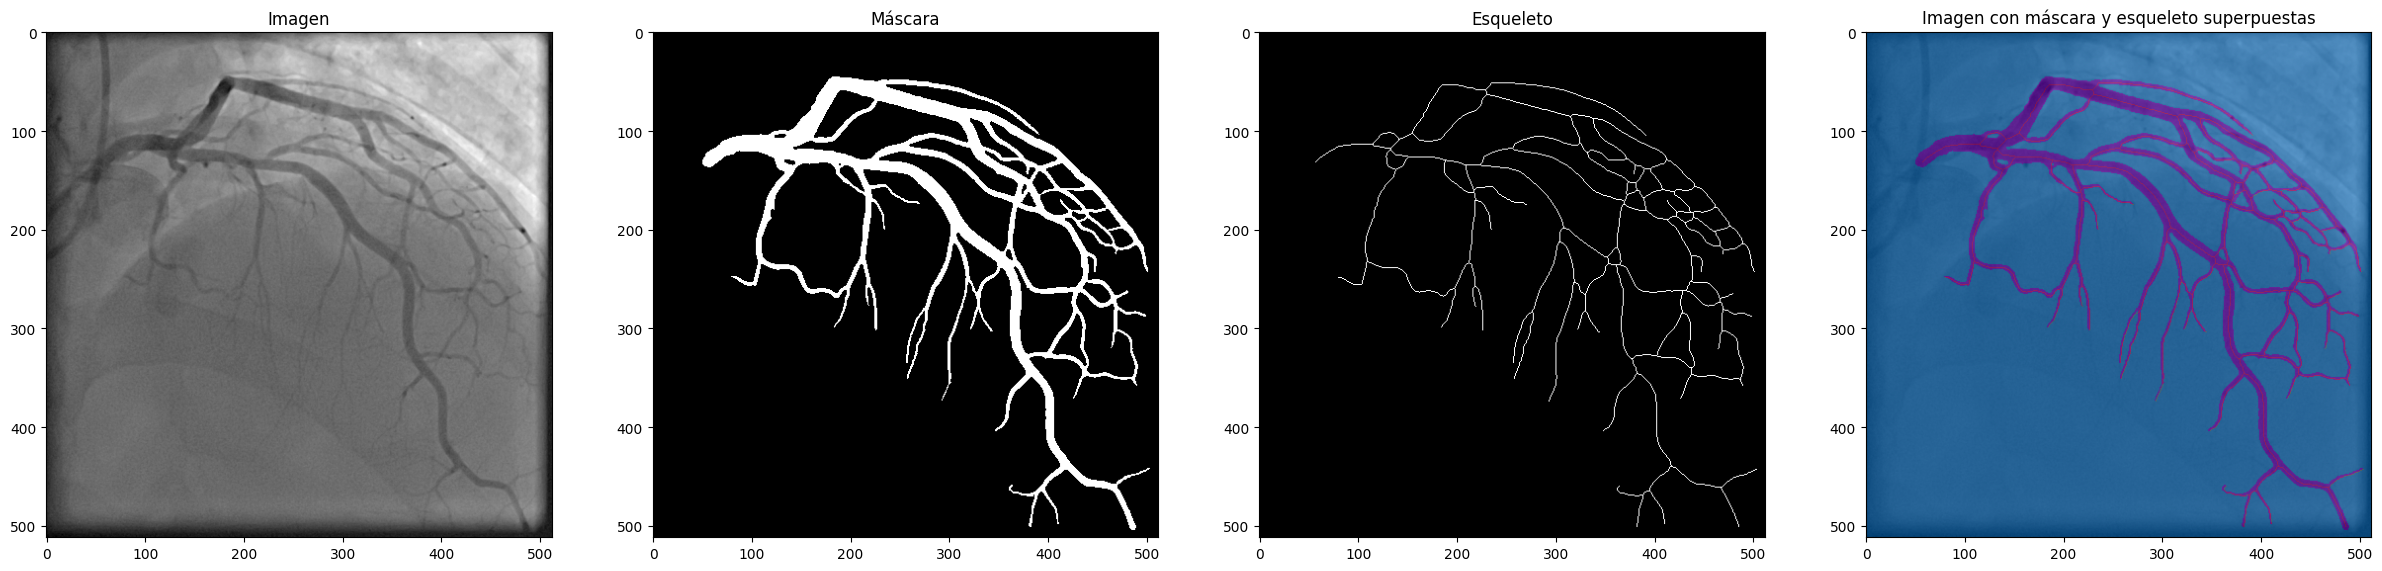

(512, 512) float32 0.84313726 0.14901961
(512, 512) float32 1.0 0.0
(512, 512) float32 1.0 0.0




In [ ]:
# Visualización de datos
imgs, masks, skelet = next(iter(train_loader))
print(f'Image shape: {imgs.shape}\nMask shape: {masks.shape}\nSkel shape: {skelet.shape}\n')

# Convertir a numpy arrays para mostrar con matplotlib
img_array = imgs[0].cpu().squeeze().numpy()  # Convertir tensor a numpy y eliminar la dimensión del lote
mask_array = masks[0].cpu().squeeze().numpy()  # Eliminar la dimensión del lote
skel_array = skelet[0].cpu().squeeze().numpy()  # Eliminar la dimensión del lote

# Configura la visualización
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 10))

# Imagen original
ax1.imshow(img_array, cmap='gray')
ax1.set_title('Imagen')

# Máscara
ax2.imshow(mask_array, cmap='gray')
ax2.set_title('Máscara')

# Esqueleto
ax3.imshow(skel_array, cmap='gray')
ax3.set_title('Esqueleto')

# Imagen con la máscara superpuesta
ax4.imshow(img_array, cmap='gray')
ax4.imshow(mask_array, cmap='cool', alpha=0.4)  # Superposición con transparencia
ax4.imshow(skel_array, cmap='jet', alpha=0.4)  # Superposición con transparencia
ax4.set_title('Imagen con máscara y esqueleto superpuestas')

plt.show()

print(img_array.shape, img_array.dtype, img_array.max(), img_array.min())
print(mask_array.shape, mask_array.dtype, mask_array.max(), mask_array.min())
print(skel_array.shape, skel_array.dtype, skel_array.max(), skel_array.min())
print('\n')

In [ ]:
#Crear data augmetation sólo para train_loader
# Definir listas para almacenar los tensores
augmented_imgs = []
augmented_masks = []
augmented_skels = []

count = 0

# Iterar sobre todos los batches en el train_loader
for batch_idx, (imgs, masks, skels) in enumerate(train_loader):
    print(f'Procesando batch {batch_idx + 1}/{len(train_loader)}...')
    for i in range(imgs.size(0)):
        img = imgs[i].squeeze().numpy()
        msk = masks[i].squeeze().numpy()
        skl = skels[i].squeeze().numpy()

        # Convertir a uint8 (valores entre 0 y 255) para aplicar transformaciones
        img = (img * 255).astype(np.uint8)
        msk = (msk * 255).astype(np.uint8)
        skl = (skl * 255).astype(np.uint8)

        hi, wi = img.shape
        center = (hi / 2, hi / 2)
        angle = 2
        angle1 = 1.5
        angle2 = -0.45
        scale = 1.0

        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        rotation_matrix1 = cv2.getRotationMatrix2D(center, angle1, scale)
        rotation_matrix2 = cv2.getRotationMatrix2D(center, angle2, scale)

        # Lista de transformaciones que se aplicarán
        transformations = [
            (img, msk, skl),  # Original
            (cv2.flip(img, 0), cv2.flip(msk, 0), cv2.flip(skl, 0)),  # Giro vertical
            (cv2.flip(img, 1), cv2.flip(msk, 1), cv2.flip(skl, 1)),  # Giro horizontal
            (cv2.flip(img, -1), cv2.flip(msk, -1), cv2.flip(skl, -1)),  # Giro vertical y horizontal
            (cv2.warpAffine(img, rotation_matrix, (wi, hi)), cv2.warpAffine(msk, rotation_matrix, (wi, hi)), cv2.warpAffine(skl, rotation_matrix, (wi, hi))),  # Rotación 2 grados
            (cv2.warpAffine(img, rotation_matrix1, (wi, hi)), cv2.warpAffine(msk, rotation_matrix1, (wi, hi)), cv2.warpAffine(skl, rotation_matrix1, (wi, hi))),  # Rotación 1.5 grados
            (cv2.warpAffine(img, rotation_matrix2, (wi, hi)), cv2.warpAffine(msk, rotation_matrix2, (wi, hi)), cv2.warpAffine(skl, rotation_matrix2, (wi, hi)))  # Rotación -0.45 grados
        ]

        # Convertir cada transformación a tensor y agregarlas a las listas
        for t_img, t_msk, t_skl in transformations:
            t_img_tensor = torch.from_numpy(t_img).float().unsqueeze(0) / 255.0  # Convertir a tensor, normalizar a [0, 1]
            t_msk_tensor = torch.from_numpy(t_msk).float().unsqueeze(0) / 255.0
            t_skl_tensor = torch.from_numpy(t_skl).float().unsqueeze(0) / 255.0

            augmented_imgs.append(t_img_tensor)
            augmented_masks.append(t_msk_tensor)
            augmented_skels.append(t_skl_tensor)

        count += 1

# Convertir las listas de tensores en tensores completos
augmented_imgs_tensor = torch.stack(augmented_imgs)
augmented_masks_tensor = torch.stack(augmented_masks)
augmented_skels_tensor = torch.stack(augmented_skels)

# Crear un nuevo DataLoader con los tensores aumentados
augmented_dataset = TensorDataset(augmented_imgs_tensor, augmented_masks_tensor, augmented_skels_tensor)
print(f'Dataset de train loader: {len(augmented_dataset)}\n')
train_loaderN = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

print(f'Terminado: {count} imágenes procesadas en total. Nuevo DataLoader creado.')

Procesando batch 1/93...
Procesando batch 2/93...
Procesando batch 3/93...
Procesando batch 4/93...
Procesando batch 5/93...
Procesando batch 6/93...
Procesando batch 7/93...
Procesando batch 8/93...
Procesando batch 9/93...
Procesando batch 10/93...
Procesando batch 11/93...
Procesando batch 12/93...
Procesando batch 13/93...
Procesando batch 14/93...
Procesando batch 15/93...
Procesando batch 16/93...
Procesando batch 17/93...
Procesando batch 18/93...
Procesando batch 19/93...
Procesando batch 20/93...
Procesando batch 21/93...
Procesando batch 22/93...
Procesando batch 23/93...
Procesando batch 24/93...
Procesando batch 25/93...
Procesando batch 26/93...
Procesando batch 27/93...
Procesando batch 28/93...
Procesando batch 29/93...
Procesando batch 30/93...
Procesando batch 31/93...
Procesando batch 32/93...
Procesando batch 33/93...
Procesando batch 34/93...
Procesando batch 35/93...
Procesando batch 36/93...
Procesando batch 37/93...
Procesando batch 38/93...
Procesando batch 39/9

In [ ]:
# Definir las métricas globalmente para evitar instanciarlas repetidamente
acc = BinaryAccuracy().to(device)
prec = BinaryPrecision().to(device)
rec = BinaryRecall().to(device)
dcs = GeneralizedDiceScore(num_classes=1).to(device)
fone = BinaryF1Score().to(device)
miou = MeanIoU(num_classes=1).to(device)

In [ ]:
def MetriX(outputs, labels):
    # Aplicar sigmoid y convertir a binario
    outputs = torch.sigmoid(outputs) > 0.5
    labels = labels > 0.5


    # Calcular IOU
    total_ious = miou(outputs, labels).item()

    # Calcular Accuracy
    total_accuracy = acc(outputs, labels).item()

    # Calcular Precision
    total_precision = prec(outputs, labels).item()

    # Calcular Recall
    total_recall = rec(outputs, labels).item()

    # Calcular F1
    total_fones = fone(outputs, labels).item()

    # Calcular Dice Score
    total_dice = dcs(outputs, labels).item()

    return total_ious, total_accuracy, total_precision, total_recall, total_fones, total_dice

In [ ]:
def Hausdorff_distance1(outputs, labels):
    outputs = (torch.sigmoid(outputs) > 0.5).cpu().detach()
    labels = (labels > 0.5).cpu().detach()
    haus = []

    # Recorrer el batch para calcular la distancia de Hausdorff para cada imagen
    for i in range(outputs.size(0)):
        outs = outputs[i].squeeze().numpy()  # Convertir a numpy
        labs = labels[i].squeeze().numpy()  # Convertir a numpy
        hd = hausdorff_distance(outs, labs)  # Calcular distancia
        haus.append(hd)  # Agregar la distancia a la lista

    return  sum(haus)/len(haus)  # Devolver un tensor con todas las distancias

In [ ]:
class IouDiceLoss(nn.Module):
    def __init__(self, alpha=0.5):

        super(IouDiceLoss, self).__init__()
        self.alpha = alpha

    def forward(self, pred, target, smooth=1e-6):
        # Convertir predicciones a probabilidades
        pred = torch.sigmoid(pred)
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        # Calcular la intersección
        intersection = (pred_flat * target_flat).sum()

        # Calcular la unión
        union = pred_flat.sum() + target_flat.sum() - intersection

        # Calcular IoU
        iou_score = (intersection + smooth) / (union + smooth)

        # Calcular Dice Score
        dice_score = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

        # Calcular pérdidas
        dice_loss = 1 - dice_score
        iou_loss = 1 - iou_score

        # Fusionar las pérdidas
        loss = self.alpha * dice_loss + (1 - self.alpha) * iou_loss
        return loss  # Devolver la pérdida y ambos scores

In [ ]:
def trainModel(model, train_loaderN, val_loader, epochs, lr):
    model = model.to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)



    #criterion = torch.nn.BCEWithLogitsLoss()
    criterion = IouDiceLoss(alpha=0.5)

    # Historial de pérdidas y métricas
    hist = {'TrainLoss_Seg': [], 'ValLoss_Seg': [], 'TrainLoss_Skel': [], 'ValLoss_Skel': []}
    hist2 = {'TrainIoU_Seg': [], 'ValIoU_Seg': [], 'TrainIoU_Skel': [], 'ValIoU_Skel': []}
    hist3 = {'TrainDice_Seg': [], 'ValDice_Seg': [], 'TrainDice_Skel': [], 'ValDice_Skel': []}
    hist4 = {'TrainHaus_Seg': [], 'ValHaus_Seg': [], 'TrainHaus_Skel': [], 'ValHaus_Skel': []}
    hist5 = {'TrainAcc_Seg': [], 'ValAcc_Seg': [], 'TrainAcc_Skel': [], 'ValAcc_Skel': [],
             'TrainPrec_Seg': [], 'ValPrec_Seg': [], 'TrainPrec_Skel': [], 'ValPrec_Skel': [],
             'TrainRecall_Seg': [], 'ValRecall_Seg': [], 'TrainRecall_Skel': [], 'ValRecall_Skel': [],
             'TrainF1_Seg': [], 'ValF1_Seg': [], 'TrainF1_Skel': [], 'ValF1_Skel': []}

    best_val_loss = float('inf')  # Inicializamos el mejor val_loss como infinito

    for epoch in range(1, epochs + 1):
        train_lossSeg, train_lossSkel, val_lossSeg, val_lossSkel = [], [], [], []
        train_iouSeg, train_iouSkel, val_iouSeg, val_iouSkel = [], [], [], []
        train_diceSeg, train_diceSkel, val_diceSeg, val_diceSkel = [], [], [], []
        train_hausSeg, train_hausSkel, val_hausSeg, val_hausSkel = [], [], [], []
        train_accSeg, train_accSkel, val_accSeg, val_accSkel = [], [], [], []
        train_precSeg, train_precSkel, val_precSeg, val_precSkel = [], [], [], []
        train_recallSeg, train_recallSkel, val_recallSeg, val_recallSkel = [], [], [], []
        train_f1Seg, train_f1Skel, val_f1Seg, val_f1Skel = [], [], [], []

        print('------------------------------------------------------------------------------')

        # Entrenamiento
        model.train()
        train_bar = tqdm(train_loaderN, desc=f"\nTraining_Epoch: {epoch}/{epochs}\n")
        for imgs, msks, skls in train_bar:
            imgs, msks, skls = imgs.to(device), msks.to(device), skls.to(device)
            predSeg, predSkel = model(imgs)

            # Pérdidas de segmentación y esqueleto
            lossSeg = criterion(predSeg, msks)
            lossSkel = criterion(predSkel, skls)
            lossTotal = lossSeg + lossSkel
            optimizer.zero_grad()
            lossTotal.backward()
            optimizer.step()

            # Cálculo de métricas
            iouSeg, accSeg, precSeg, recallSeg, f1Seg, diceSeg = MetriX(predSeg, msks)
            iouSkel, accSkel, precSkel, recallSkel, f1Skel, diceSkel = MetriX(predSkel, skls)
            hausSeg = Hausdorff_distance1(predSeg,msks)
            hausSkel = Hausdorff_distance1(predSkel,skls)

            # Almacenar las pérdidas y métricas de entrenamiento
            train_lossSeg.append(lossSeg.item())
            train_lossSkel.append(lossSkel.item())
            train_iouSeg.append(iouSeg)
            train_diceSeg.append(diceSeg)
            train_iouSkel.append(iouSkel)
            train_diceSkel.append(diceSkel)
            train_accSeg.append(accSeg)
            train_accSkel.append(accSkel)
            train_precSeg.append(precSeg)
            train_precSkel.append(precSkel)
            train_recallSeg.append(recallSeg)
            train_recallSkel.append(recallSkel)
            train_f1Seg.append(f1Seg)
            train_f1Skel.append(f1Skel)
            train_hausSeg.append(hausSeg)
            train_hausSkel.append(hausSkel)


            train_bar.set_description(f"Train_seg_loss {np.mean(train_lossSeg):.5f} Train_skel_loss {np.mean(train_lossSkel):.5f}")
                                      #Train_seg_iou {np.mean(train_iouSeg):.5f}Train_skel_iou {np.mean(train_iouSkel):.5f}Train_seg_dice {np.mean(train_diceSeg):.5f}Train_skel_dice {np.mean(train_diceSkel):.5f}")

        all_pred_seg = []
        all_pred_skel = []
        # Validación
        with torch.no_grad():
          model.eval()
          val_bar = tqdm(val_loader, desc=f'\nValidation_epoch: {epoch}/{epochs}\n')
          for imgs, msks, skls in val_bar:
              imgs, msks, skls = imgs.to(device), msks.to(device), skls.to(device)
              predSeg, predSkel = model(imgs)

              # Pérdidas de validación
              vallossSeg = criterion(predSeg, msks)
              vallossSkel = criterion(predSkel, skls)
              #val_lossTotal = vallossSeg + vallossSkel

              # Cálculo de métricas
              iouSeg, accSeg, precSeg, recallSeg, f1Seg, diceSeg = MetriX(predSeg, msks)
              iouSkel, accSkel, precSkel, recallSkel, f1Skel, diceSkel = MetriX(predSkel, skls)
              hausSeg = Hausdorff_distance1(predSeg,msks)
              hausSkel = Hausdorff_distance1(predSkel,skls)

              # Almacenar las pérdidas y métricas de entrenamiento
              val_lossSeg.append(vallossSeg.item())
              val_lossSkel.append(vallossSkel.item())
              val_iouSeg.append(iouSeg)
              val_diceSeg.append(diceSeg)
              val_iouSkel.append(iouSkel)
              val_diceSkel.append(diceSkel)
              val_accSeg.append(accSeg)
              val_accSkel.append(accSkel)
              val_precSeg.append(precSeg)
              val_precSkel.append(precSkel)
              val_recallSeg.append(recallSeg)
              val_recallSkel.append(recallSkel)
              val_f1Seg.append(f1Seg)
              val_f1Skel.append(f1Skel)
              val_hausSeg.append(hausSeg)
              val_hausSkel.append(hausSkel)

              # Almacenar predicciones en listas
              all_pred_seg.append(torch.sigmoid(predSeg).cpu().detach())
              all_pred_skel.append(torch.sigmoid(predSkel).cpu().detach())

              val_bar.set_description(f"Val_seg_loss {np.mean(val_lossSeg):.5f}Val_skel_loss {np.mean(val_lossSkel):.5f}")
                                      #Val_seg_iou {np.mean(val_iouSeg):.5f}Val_skel_iou {np.mean(val_iouSkel):.5f}Val_seg_dice {np.mean(val_diceSeg):.5f}Val_skel_dice {np.mean(val_diceSkel):.5f}")

          #Guardar mejor modelo basado en la pérdida de validación
          #Guardar predicciones cada 15 épocas

          # Guardar las predicciones de toda la época después de iterar sobre todos los batches
          if epoch % 15 == 0:
              for batch_idx in range(len(all_pred_seg)):
                  for i in range(all_pred_seg[batch_idx].size(0)):
                      pred_seg = all_pred_seg[batch_idx][i].squeeze().numpy()
                      pred_skel = all_pred_skel[batch_idx][i].squeeze().numpy()

                      file_path_seg = os.path.join(save_path1, f"PredictionVal_{epoch}_Seg_{batch_idx * batch_size + i}_UnetMultiTask_16INIDLossAttention.png")
                      file_path_skel = os.path.join(save_path2, f"PredictionVal_{epoch}_Skel_{batch_idx * batch_size + i}_UnetMultiTask_16INIDLossAttention.png")
                      plt.imsave(file_path_seg, pred_seg, cmap='gray')
                      plt.imsave(file_path_skel, pred_skel, cmap='gray')



        val_loss_total =  (sum(val_lossSeg)/len(val_lossSeg)) + (sum(val_lossSkel)/len(val_lossSkel))
        if val_loss_total < best_val_loss:
            best_val_loss = val_loss_total
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model_UnetMultiTask_16INIDLossAttention.pth'))
            print(f'\nMejor modelo guardado en la época {epoch} es: {best_val_loss}')

        # Actualizar el scheduler
        scheduler.step(val_loss_total)

        # Almacenar el historial
        hist['TrainLoss_Seg'].append(sum(train_lossSeg) / len(train_lossSeg))
        hist['ValLoss_Seg'].append(sum(val_lossSeg) / len(val_lossSeg))
        hist['TrainLoss_Skel'].append(sum(train_lossSkel) / len(train_lossSkel))
        hist['ValLoss_Skel'].append(sum(val_lossSkel) / len(val_lossSkel))

        hist2['TrainIoU_Seg'].append(sum(train_iouSeg) / len(train_iouSeg))
        hist2['ValIoU_Seg'].append(sum(val_iouSeg) / len(val_iouSeg))
        hist2['TrainIoU_Skel'].append(sum(train_iouSkel) / len(train_iouSkel))
        hist2['ValIoU_Skel'].append(sum(val_iouSkel) / len(val_iouSkel))

        hist3['TrainDice_Seg'].append(sum(train_diceSeg) / len(train_diceSeg))
        hist3['ValDice_Seg'].append(sum(val_diceSeg) / len(val_diceSeg))
        hist3['TrainDice_Skel'].append(sum(train_diceSkel) / len(train_diceSkel))
        hist3['ValDice_Skel'].append(sum(val_diceSkel) / len(val_diceSkel))

        hist4['TrainHaus_Seg'].append(sum(train_hausSeg) / len(train_hausSeg))
        hist4['ValHaus_Seg'].append(sum(val_hausSeg) / len(val_hausSeg))
        hist4['TrainHaus_Skel'].append(sum(train_hausSkel) / len(train_hausSkel))
        hist4['ValHaus_Skel'].append(sum(val_hausSkel) / len(val_hausSkel))

        hist5['TrainAcc_Seg'].append(sum(train_accSeg) / len(train_accSeg))
        hist5['ValAcc_Seg'].append(sum(val_accSeg) / len(val_accSeg))
        hist5['TrainAcc_Skel'].append(sum(train_accSkel) / len(train_accSkel))
        hist5['ValAcc_Skel'].append(sum(val_accSkel) / len(val_accSkel))

        hist5['TrainPrec_Seg'].append(sum(train_precSeg) / len(train_precSeg))
        hist5['ValPrec_Seg'].append(sum(val_precSeg) / len(val_precSeg))
        hist5['TrainPrec_Skel'].append(sum(train_precSkel) / len(train_precSkel))
        hist5['ValPrec_Skel'].append(sum(val_precSkel) / len(val_precSkel))

        hist5['TrainRecall_Seg'].append(sum(train_recallSeg) / len(train_recallSeg))
        hist5['ValRecall_Seg'].append(sum(val_recallSeg) / len(val_recallSeg))
        hist5['TrainRecall_Skel'].append(sum(train_recallSkel) / len(train_recallSkel))
        hist5['ValRecall_Skel'].append(sum(val_recallSkel) / len(val_recallSkel))

        hist5['TrainF1_Seg'].append(sum(train_f1Seg) / len(train_f1Seg))
        hist5['ValF1_Seg'].append(sum(val_f1Seg) / len(val_f1Seg))
        hist5['TrainF1_Skel'].append(sum(train_f1Skel) / len(train_f1Skel))
        hist5['ValF1_Skel'].append(sum(val_f1Skel) / len(val_f1Skel))

        print(f"\nEpoch {epoch}/{epochs} - "
            f"TrainlossSeg: {np.mean(train_lossSeg):.5f}, Trainlossskel: {np.mean(train_lossSkel):.5f} - "
            f"VallossSeg: {np.mean(val_lossSeg):.5f}, VallossSkel: {np.mean(val_lossSkel):.5f}\n")



    return hist, hist2, hist3, hist4, hist5

In [ ]:
hist, hist2, hist3, hist4, hist5 = trainModel(model, train_loader, val_loader, epochs, l_rate)

------------------------------------------------------------------------------



Training_Epoch: 1/150
Train_seg_loss 0.71397 Train_skel_loss 0.95186: 100%|██████████| 93/93 [01:43<00:00,  1.12s/it]

Validation_epoch: 1/150
Val_seg_loss 0.48596Val_skel_loss 0.86866: 100%|██████████| 16/16 [02:19<00:00,  8.74s/it]



Mejor modelo guardado en la época 1 es: 1.3546197228133678

Epoch 1/150 - TrainlossSeg: 0.71397, Trainlossskel: 0.95186 - VallossSeg: 0.48596, VallossSkel: 0.86866

------------------------------------------------------------------------------



Training_Epoch: 2/150
Train_seg_loss 0.39635 Train_skel_loss 0.76826: 100%|██████████| 93/93 [00:41<00:00,  2.22it/s]

Validation_epoch: 2/150
Val_seg_loss 0.35160Val_skel_loss 0.71650: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]



Mejor modelo guardado en la época 2 es: 1.0681047905236483

Epoch 2/150 - TrainlossSeg: 0.39635, Trainlossskel: 0.76826 - VallossSeg: 0.35160, VallossSkel: 0.71650

------------------------------------------------------------------------------



Training_Epoch: 3/150
Train_seg_loss 0.34359 Train_skel_loss 0.68761: 100%|██████████| 93/93 [00:40<00:00,  2.28it/s]

Validation_epoch: 3/150
Val_seg_loss 0.31285Val_skel_loss 0.66921: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]



Mejor modelo guardado en la época 3 es: 0.9820599295198917

Epoch 3/150 - TrainlossSeg: 0.34359, Trainlossskel: 0.68761 - VallossSeg: 0.31285, VallossSkel: 0.66921

------------------------------------------------------------------------------



Training_Epoch: 4/150
Train_seg_loss 0.31577 Train_skel_loss 0.65228: 100%|██████████| 93/93 [00:40<00:00,  2.30it/s]

Validation_epoch: 4/150
Val_seg_loss 0.29382Val_skel_loss 0.62415: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]



Mejor modelo guardado en la época 4 es: 0.9179780688136816

Epoch 4/150 - TrainlossSeg: 0.31577, Trainlossskel: 0.65228 - VallossSeg: 0.29382, VallossSkel: 0.62415

------------------------------------------------------------------------------



Training_Epoch: 5/150
Train_seg_loss 0.29374 Train_skel_loss 0.62997: 100%|██████████| 93/93 [00:40<00:00,  2.32it/s]

Validation_epoch: 5/150
Val_seg_loss 0.28185Val_skel_loss 0.61500: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Mejor modelo guardado en la época 5 es: 0.8968434762209654

Epoch 5/150 - TrainlossSeg: 0.29374, Trainlossskel: 0.62997 - VallossSeg: 0.28185, VallossSkel: 0.61500

------------------------------------------------------------------------------



Training_Epoch: 6/150
Train_seg_loss 0.28401 Train_skel_loss 0.61632: 100%|██████████| 93/93 [00:39<00:00,  2.33it/s]

Validation_epoch: 6/150
Val_seg_loss 0.26641Val_skel_loss 0.59724: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Mejor modelo guardado en la época 6 es: 0.863647373393178

Epoch 6/150 - TrainlossSeg: 0.28401, Trainlossskel: 0.61632 - VallossSeg: 0.26641, VallossSkel: 0.59724

------------------------------------------------------------------------------



Training_Epoch: 7/150
Train_seg_loss 0.26643 Train_skel_loss 0.60298: 100%|██████████| 93/93 [00:39<00:00,  2.34it/s]

Validation_epoch: 7/150
Val_seg_loss 0.25747Val_skel_loss 0.58511: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]



Mejor modelo guardado en la época 7 es: 0.8425777871161699

Epoch 7/150 - TrainlossSeg: 0.26643, Trainlossskel: 0.60298 - VallossSeg: 0.25747, VallossSkel: 0.58511

------------------------------------------------------------------------------



Training_Epoch: 8/150
Train_seg_loss 0.25833 Train_skel_loss 0.59101: 100%|██████████| 93/93 [00:39<00:00,  2.34it/s]

Validation_epoch: 8/150
Val_seg_loss 0.23241Val_skel_loss 0.57370: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Mejor modelo guardado en la época 8 es: 0.8061092216521502

Epoch 8/150 - TrainlossSeg: 0.25833, Trainlossskel: 0.59101 - VallossSeg: 0.23241, VallossSkel: 0.57370

------------------------------------------------------------------------------



Training_Epoch: 9/150
Train_seg_loss 0.25027 Train_skel_loss 0.58050: 100%|██████████| 93/93 [00:39<00:00,  2.35it/s]

Validation_epoch: 9/150
Val_seg_loss 0.23968Val_skel_loss 0.57065: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Epoch 9/150 - TrainlossSeg: 0.25027, Trainlossskel: 0.58050 - VallossSeg: 0.23968, VallossSkel: 0.57065

------------------------------------------------------------------------------



Training_Epoch: 10/150
Train_seg_loss 0.23677 Train_skel_loss 0.57359: 100%|██████████| 93/93 [00:39<00:00,  2.36it/s]

Validation_epoch: 10/150
Val_seg_loss 0.23099Val_skel_loss 0.57758: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]



Epoch 10/150 - TrainlossSeg: 0.23677, Trainlossskel: 0.57359 - VallossSeg: 0.23099, VallossSkel: 0.57758

------------------------------------------------------------------------------



Training_Epoch: 11/150
Train_seg_loss 0.23885 Train_skel_loss 0.56971: 100%|██████████| 93/93 [00:39<00:00,  2.36it/s]

Validation_epoch: 11/150
Val_seg_loss 0.26790Val_skel_loss 0.60732: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Epoch 11/150 - TrainlossSeg: 0.23885, Trainlossskel: 0.56971 - VallossSeg: 0.26790, VallossSkel: 0.60732

------------------------------------------------------------------------------



Training_Epoch: 12/150
Train_seg_loss 0.24856 Train_skel_loss 0.58177: 100%|██████████| 93/93 [00:39<00:00,  2.35it/s]

Validation_epoch: 12/150
Val_seg_loss 0.24899Val_skel_loss 0.56787: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]



Epoch 12/150 - TrainlossSeg: 0.24856, Trainlossskel: 0.58177 - VallossSeg: 0.24899, VallossSkel: 0.56787

------------------------------------------------------------------------------



Training_Epoch: 13/150
Train_seg_loss 0.22406 Train_skel_loss 0.55860: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 13/150
Val_seg_loss 0.22623Val_skel_loss 0.55150: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]



Mejor modelo guardado en la época 13 es: 0.7777363527566195

Epoch 13/150 - TrainlossSeg: 0.22406, Trainlossskel: 0.55860 - VallossSeg: 0.22623, VallossSkel: 0.55150

------------------------------------------------------------------------------



Training_Epoch: 14/150
Train_seg_loss 0.22459 Train_skel_loss 0.55701: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 14/150
Val_seg_loss 0.21713Val_skel_loss 0.55823: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]



Mejor modelo guardado en la época 14 es: 0.7753582373261452

Epoch 14/150 - TrainlossSeg: 0.22459, Trainlossskel: 0.55701 - VallossSeg: 0.21713, VallossSkel: 0.55823

------------------------------------------------------------------------------



Training_Epoch: 15/150
Train_seg_loss 0.22181 Train_skel_loss 0.55026: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 15/150
Val_seg_loss 0.21322Val_skel_loss 0.55608: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]



Mejor modelo guardado en la época 15 es: 0.7693021688610315

Epoch 15/150 - TrainlossSeg: 0.22181, Trainlossskel: 0.55026 - VallossSeg: 0.21322, VallossSkel: 0.55608

------------------------------------------------------------------------------



Training_Epoch: 16/150
Train_seg_loss 0.21185 Train_skel_loss 0.54594: 100%|██████████| 93/93 [00:39<00:00,  2.36it/s]

Validation_epoch: 16/150
Val_seg_loss 0.20460Val_skel_loss 0.54660: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Mejor modelo guardado en la época 16 es: 0.751199459657073

Epoch 16/150 - TrainlossSeg: 0.21185, Trainlossskel: 0.54594 - VallossSeg: 0.20460, VallossSkel: 0.54660

------------------------------------------------------------------------------



Training_Epoch: 17/150
Train_seg_loss 0.21126 Train_skel_loss 0.54742: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 17/150
Val_seg_loss 0.20637Val_skel_loss 0.54273: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Mejor modelo guardado en la época 17 es: 0.7491004038602114

Epoch 17/150 - TrainlossSeg: 0.21126, Trainlossskel: 0.54742 - VallossSeg: 0.20637, VallossSkel: 0.54273

------------------------------------------------------------------------------



Training_Epoch: 18/150
Train_seg_loss 0.20778 Train_skel_loss 0.54217: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 18/150
Val_seg_loss 0.20554Val_skel_loss 0.55060: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 18/150 - TrainlossSeg: 0.20778, Trainlossskel: 0.54217 - VallossSeg: 0.20554, VallossSkel: 0.55060

------------------------------------------------------------------------------



Training_Epoch: 19/150
Train_seg_loss 0.20751 Train_skel_loss 0.54209: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 19/150
Val_seg_loss 0.22100Val_skel_loss 0.54742: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]



Epoch 19/150 - TrainlossSeg: 0.20751, Trainlossskel: 0.54209 - VallossSeg: 0.22100, VallossSkel: 0.54742

------------------------------------------------------------------------------



Training_Epoch: 20/150
Train_seg_loss 0.20351 Train_skel_loss 0.54415: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 20/150
Val_seg_loss 0.21020Val_skel_loss 0.54769: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]



Epoch 20/150 - TrainlossSeg: 0.20351, Trainlossskel: 0.54415 - VallossSeg: 0.21020, VallossSkel: 0.54769

------------------------------------------------------------------------------



Training_Epoch: 21/150
Train_seg_loss 0.20067 Train_skel_loss 0.53828: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 21/150
Val_seg_loss 0.20295Val_skel_loss 0.53720: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Mejor modelo guardado en la época 21 es: 0.7401522118598223

Epoch 21/150 - TrainlossSeg: 0.20067, Trainlossskel: 0.53828 - VallossSeg: 0.20295, VallossSkel: 0.53720

------------------------------------------------------------------------------



Training_Epoch: 22/150
Train_seg_loss 0.19493 Train_skel_loss 0.53097: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 22/150
Val_seg_loss 0.20665Val_skel_loss 0.53332: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]



Mejor modelo guardado en la época 22 es: 0.7399729918688536

Epoch 22/150 - TrainlossSeg: 0.19493, Trainlossskel: 0.53097 - VallossSeg: 0.20665, VallossSkel: 0.53332

------------------------------------------------------------------------------



Training_Epoch: 23/150
Train_seg_loss 0.19106 Train_skel_loss 0.52603: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 23/150
Val_seg_loss 0.19440Val_skel_loss 0.54101: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Mejor modelo guardado en la época 23 es: 0.7354146540164948

Epoch 23/150 - TrainlossSeg: 0.19106, Trainlossskel: 0.52603 - VallossSeg: 0.19440, VallossSkel: 0.54101

------------------------------------------------------------------------------



Training_Epoch: 24/150
Train_seg_loss 0.19095 Train_skel_loss 0.52884: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 24/150
Val_seg_loss 0.19017Val_skel_loss 0.53135: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Mejor modelo guardado en la época 24 es: 0.7215220909565687

Epoch 24/150 - TrainlossSeg: 0.19095, Trainlossskel: 0.52884 - VallossSeg: 0.19017, VallossSkel: 0.53135

------------------------------------------------------------------------------



Training_Epoch: 25/150
Train_seg_loss 0.18975 Train_skel_loss 0.52789: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 25/150
Val_seg_loss 0.21817Val_skel_loss 0.54035: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 25/150 - TrainlossSeg: 0.18975, Trainlossskel: 0.52789 - VallossSeg: 0.21817, VallossSkel: 0.54035

------------------------------------------------------------------------------



Training_Epoch: 26/150
Train_seg_loss 0.19377 Train_skel_loss 0.53010: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 26/150
Val_seg_loss 0.19360Val_skel_loss 0.52473: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Mejor modelo guardado en la época 26 es: 0.7183292023837566

Epoch 26/150 - TrainlossSeg: 0.19377, Trainlossskel: 0.53010 - VallossSeg: 0.19360, VallossSkel: 0.52473

------------------------------------------------------------------------------



Training_Epoch: 27/150
Train_seg_loss 0.18561 Train_skel_loss 0.52077: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 27/150
Val_seg_loss 0.20088Val_skel_loss 0.52863: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 27/150 - TrainlossSeg: 0.18561, Trainlossskel: 0.52077 - VallossSeg: 0.20088, VallossSkel: 0.52863

------------------------------------------------------------------------------



Training_Epoch: 28/150
Train_seg_loss 0.18734 Train_skel_loss 0.52408: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 28/150
Val_seg_loss 0.19836Val_skel_loss 0.52739: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]



Epoch 28/150 - TrainlossSeg: 0.18734, Trainlossskel: 0.52408 - VallossSeg: 0.19836, VallossSkel: 0.52739

------------------------------------------------------------------------------



Training_Epoch: 29/150
Train_seg_loss 0.18584 Train_skel_loss 0.52585: 100%|██████████| 93/93 [00:39<00:00,  2.37it/s]

Validation_epoch: 29/150
Val_seg_loss 0.19144Val_skel_loss 0.53077: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 29/150 - TrainlossSeg: 0.18584, Trainlossskel: 0.52585 - VallossSeg: 0.19144, VallossSkel: 0.53077

------------------------------------------------------------------------------



Training_Epoch: 30/150
Train_seg_loss 0.18460 Train_skel_loss 0.52356: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 30/150
Val_seg_loss 0.19384Val_skel_loss 0.53335: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 30/150 - TrainlossSeg: 0.18460, Trainlossskel: 0.52356 - VallossSeg: 0.19384, VallossSkel: 0.53335

------------------------------------------------------------------------------



Training_Epoch: 31/150
Train_seg_loss 0.18072 Train_skel_loss 0.51655: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 31/150
Val_seg_loss 0.18777Val_skel_loss 0.52482: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Mejor modelo guardado en la época 31 es: 0.7125898990780115

Epoch 31/150 - TrainlossSeg: 0.18072, Trainlossskel: 0.51655 - VallossSeg: 0.18777, VallossSkel: 0.52482

------------------------------------------------------------------------------



Training_Epoch: 32/150
Train_seg_loss 0.17593 Train_skel_loss 0.51423: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 32/150
Val_seg_loss 0.19266Val_skel_loss 0.53908: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Epoch 32/150 - TrainlossSeg: 0.17593, Trainlossskel: 0.51423 - VallossSeg: 0.19266, VallossSkel: 0.53908

------------------------------------------------------------------------------



Training_Epoch: 33/150
Train_seg_loss 0.19358 Train_skel_loss 0.52787: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 33/150
Val_seg_loss 0.20318Val_skel_loss 0.52313: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]



Epoch 33/150 - TrainlossSeg: 0.19358, Trainlossskel: 0.52787 - VallossSeg: 0.20318, VallossSkel: 0.52313

------------------------------------------------------------------------------



Training_Epoch: 34/150
Train_seg_loss 0.18595 Train_skel_loss 0.51753: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 34/150
Val_seg_loss 0.19135Val_skel_loss 0.52610: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]



Epoch 34/150 - TrainlossSeg: 0.18595, Trainlossskel: 0.51753 - VallossSeg: 0.19135, VallossSkel: 0.52610

------------------------------------------------------------------------------



Training_Epoch: 35/150
Train_seg_loss 0.18979 Train_skel_loss 0.52289: 100%|██████████| 93/93 [00:39<00:00,  2.38it/s]

Validation_epoch: 35/150
Val_seg_loss 0.20074Val_skel_loss 0.53295: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]



Epoch 35/150 - TrainlossSeg: 0.18979, Trainlossskel: 0.52289 - VallossSeg: 0.20074, VallossSkel: 0.53295

------------------------------------------------------------------------------



Training_Epoch: 36/150
Train_seg_loss 0.18358 Train_skel_loss 0.51649: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 36/150
Val_seg_loss 0.19551Val_skel_loss 0.51664: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]



Mejor modelo guardado en la época 36 es: 0.7121538892388344

Epoch 36/150 - TrainlossSeg: 0.18358, Trainlossskel: 0.51649 - VallossSeg: 0.19551, VallossSkel: 0.51664

------------------------------------------------------------------------------



Training_Epoch: 37/150
Train_seg_loss 0.17569 Train_skel_loss 0.51077: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 37/150
Val_seg_loss 0.18634Val_skel_loss 0.52099: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Mejor modelo guardado en la época 37 es: 0.7073314171284437

Epoch 37/150 - TrainlossSeg: 0.17569, Trainlossskel: 0.51077 - VallossSeg: 0.18634, VallossSkel: 0.52099

------------------------------------------------------------------------------



Training_Epoch: 38/150
Train_seg_loss 0.17952 Train_skel_loss 0.51644: 100%|██████████| 93/93 [00:38<00:00,  2.38it/s]

Validation_epoch: 38/150
Val_seg_loss 0.17915Val_skel_loss 0.51669: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Mejor modelo guardado en la época 38 es: 0.6958315391093493

Epoch 38/150 - TrainlossSeg: 0.17952, Trainlossskel: 0.51644 - VallossSeg: 0.17915, VallossSkel: 0.51669

------------------------------------------------------------------------------



Training_Epoch: 39/150
Train_seg_loss 0.17518 Train_skel_loss 0.51383: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 39/150
Val_seg_loss 0.18948Val_skel_loss 0.51831: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 39/150 - TrainlossSeg: 0.17518, Trainlossskel: 0.51383 - VallossSeg: 0.18948, VallossSkel: 0.51831

------------------------------------------------------------------------------



Training_Epoch: 40/150
Train_seg_loss 0.16916 Train_skel_loss 0.50716: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 40/150
Val_seg_loss 0.19008Val_skel_loss 0.52685: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 40/150 - TrainlossSeg: 0.16916, Trainlossskel: 0.50716 - VallossSeg: 0.19008, VallossSkel: 0.52685

------------------------------------------------------------------------------



Training_Epoch: 41/150
Train_seg_loss 0.16836 Train_skel_loss 0.50950: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 41/150
Val_seg_loss 0.17932Val_skel_loss 0.52324: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 41/150 - TrainlossSeg: 0.16836, Trainlossskel: 0.50950 - VallossSeg: 0.17932, VallossSkel: 0.52324

------------------------------------------------------------------------------



Training_Epoch: 42/150
Train_seg_loss 0.16582 Train_skel_loss 0.50480: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 42/150
Val_seg_loss 0.18626Val_skel_loss 0.51939: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 42/150 - TrainlossSeg: 0.16582, Trainlossskel: 0.50480 - VallossSeg: 0.18626, VallossSkel: 0.51939

------------------------------------------------------------------------------



Training_Epoch: 43/150
Train_seg_loss 0.17397 Train_skel_loss 0.51291: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 43/150
Val_seg_loss 0.18289Val_skel_loss 0.51624: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]



Epoch 43/150 - TrainlossSeg: 0.17397, Trainlossskel: 0.51291 - VallossSeg: 0.18289, VallossSkel: 0.51624

------------------------------------------------------------------------------



Training_Epoch: 44/150
Train_seg_loss 0.16598 Train_skel_loss 0.50141: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 44/150
Val_seg_loss 0.18210Val_skel_loss 0.51815: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 44/150 - TrainlossSeg: 0.16598, Trainlossskel: 0.50141 - VallossSeg: 0.18210, VallossSkel: 0.51815

------------------------------------------------------------------------------



Training_Epoch: 45/150
Train_seg_loss 0.15148 Train_skel_loss 0.48349: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 45/150
Val_seg_loss 0.17063Val_skel_loss 0.50042: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Mejor modelo guardado en la época 45 es: 0.6710451692342758

Epoch 45/150 - TrainlossSeg: 0.15148, Trainlossskel: 0.48349 - VallossSeg: 0.17063, VallossSkel: 0.50042

------------------------------------------------------------------------------



Training_Epoch: 46/150
Train_seg_loss 0.14513 Train_skel_loss 0.47712: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 46/150
Val_seg_loss 0.16885Val_skel_loss 0.49957: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Mejor modelo guardado en la época 46 es: 0.6684202831238508

Epoch 46/150 - TrainlossSeg: 0.14513, Trainlossskel: 0.47712 - VallossSeg: 0.16885, VallossSkel: 0.49957

------------------------------------------------------------------------------



Training_Epoch: 47/150
Train_seg_loss 0.14504 Train_skel_loss 0.47663: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 47/150
Val_seg_loss 0.17000Val_skel_loss 0.50147: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 47/150 - TrainlossSeg: 0.14504, Trainlossskel: 0.47663 - VallossSeg: 0.17000, VallossSkel: 0.50147

------------------------------------------------------------------------------



Training_Epoch: 48/150
Train_seg_loss 0.14337 Train_skel_loss 0.47402: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 48/150
Val_seg_loss 0.16839Val_skel_loss 0.49977: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Mejor modelo guardado en la época 48 es: 0.6681586354970932

Epoch 48/150 - TrainlossSeg: 0.14337, Trainlossskel: 0.47402 - VallossSeg: 0.16839, VallossSkel: 0.49977

------------------------------------------------------------------------------



Training_Epoch: 49/150
Train_seg_loss 0.14282 Train_skel_loss 0.47272: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 49/150
Val_seg_loss 0.16995Val_skel_loss 0.50056: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 49/150 - TrainlossSeg: 0.14282, Trainlossskel: 0.47272 - VallossSeg: 0.16995, VallossSkel: 0.50056

------------------------------------------------------------------------------



Training_Epoch: 50/150
Train_seg_loss 0.14176 Train_skel_loss 0.47404: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 50/150
Val_seg_loss 0.16906Val_skel_loss 0.49984: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 50/150 - TrainlossSeg: 0.14176, Trainlossskel: 0.47404 - VallossSeg: 0.16906, VallossSkel: 0.49984

------------------------------------------------------------------------------



Training_Epoch: 51/150
Train_seg_loss 0.14111 Train_skel_loss 0.47145: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 51/150
Val_seg_loss 0.17029Val_skel_loss 0.50096: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Epoch 51/150 - TrainlossSeg: 0.14111, Trainlossskel: 0.47145 - VallossSeg: 0.17029, VallossSkel: 0.50096

------------------------------------------------------------------------------



Training_Epoch: 52/150
Train_seg_loss 0.13998 Train_skel_loss 0.47124: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 52/150
Val_seg_loss 0.16913Val_skel_loss 0.50032: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]



Epoch 52/150 - TrainlossSeg: 0.13998, Trainlossskel: 0.47124 - VallossSeg: 0.16913, VallossSkel: 0.50032

------------------------------------------------------------------------------



Training_Epoch: 53/150
Train_seg_loss 0.13919 Train_skel_loss 0.46801: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 53/150
Val_seg_loss 0.16889Val_skel_loss 0.50047: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 53/150 - TrainlossSeg: 0.13919, Trainlossskel: 0.46801 - VallossSeg: 0.16889, VallossSkel: 0.50047

------------------------------------------------------------------------------



Training_Epoch: 54/150
Train_seg_loss 0.13879 Train_skel_loss 0.46860: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 54/150
Val_seg_loss 0.17023Val_skel_loss 0.50057: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 54/150 - TrainlossSeg: 0.13879, Trainlossskel: 0.46860 - VallossSeg: 0.17023, VallossSkel: 0.50057

------------------------------------------------------------------------------



Training_Epoch: 55/150
Train_seg_loss 0.13755 Train_skel_loss 0.46447: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 55/150
Val_seg_loss 0.16961Val_skel_loss 0.50026: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 55/150 - TrainlossSeg: 0.13755, Trainlossskel: 0.46447 - VallossSeg: 0.16961, VallossSkel: 0.50026

------------------------------------------------------------------------------



Training_Epoch: 56/150
Train_seg_loss 0.13623 Train_skel_loss 0.46317: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 56/150
Val_seg_loss 0.16956Val_skel_loss 0.50018: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 56/150 - TrainlossSeg: 0.13623, Trainlossskel: 0.46317 - VallossSeg: 0.16956, VallossSkel: 0.50018

------------------------------------------------------------------------------



Training_Epoch: 57/150
Train_seg_loss 0.13665 Train_skel_loss 0.46403: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 57/150
Val_seg_loss 0.16922Val_skel_loss 0.50003: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 57/150 - TrainlossSeg: 0.13665, Trainlossskel: 0.46403 - VallossSeg: 0.16922, VallossSkel: 0.50003

------------------------------------------------------------------------------



Training_Epoch: 58/150
Train_seg_loss 0.13686 Train_skel_loss 0.46404: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 58/150
Val_seg_loss 0.16938Val_skel_loss 0.50008: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 58/150 - TrainlossSeg: 0.13686, Trainlossskel: 0.46404 - VallossSeg: 0.16938, VallossSkel: 0.50008

------------------------------------------------------------------------------



Training_Epoch: 59/150
Train_seg_loss 0.13620 Train_skel_loss 0.46253: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 59/150
Val_seg_loss 0.16939Val_skel_loss 0.50024: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 59/150 - TrainlossSeg: 0.13620, Trainlossskel: 0.46253 - VallossSeg: 0.16939, VallossSkel: 0.50024

------------------------------------------------------------------------------



Training_Epoch: 60/150
Train_seg_loss 0.13576 Train_skel_loss 0.46171: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 60/150
Val_seg_loss 0.16936Val_skel_loss 0.50020: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 60/150 - TrainlossSeg: 0.13576, Trainlossskel: 0.46171 - VallossSeg: 0.16936, VallossSkel: 0.50020

------------------------------------------------------------------------------



Training_Epoch: 61/150
Train_seg_loss 0.13659 Train_skel_loss 0.46357: 100%|██████████| 93/93 [00:38<00:00,  2.38it/s]

Validation_epoch: 61/150
Val_seg_loss 0.16932Val_skel_loss 0.50018: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Epoch 61/150 - TrainlossSeg: 0.13659, Trainlossskel: 0.46357 - VallossSeg: 0.16932, VallossSkel: 0.50018

------------------------------------------------------------------------------



Training_Epoch: 62/150
Train_seg_loss 0.13622 Train_skel_loss 0.46155: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 62/150
Val_seg_loss 0.16932Val_skel_loss 0.50017: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 62/150 - TrainlossSeg: 0.13622, Trainlossskel: 0.46155 - VallossSeg: 0.16932, VallossSkel: 0.50017

------------------------------------------------------------------------------



Training_Epoch: 63/150
Train_seg_loss 0.13592 Train_skel_loss 0.46231: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 63/150
Val_seg_loss 0.16933Val_skel_loss 0.50017: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 63/150 - TrainlossSeg: 0.13592, Trainlossskel: 0.46231 - VallossSeg: 0.16933, VallossSkel: 0.50017

------------------------------------------------------------------------------



Training_Epoch: 64/150
Train_seg_loss 0.13609 Train_skel_loss 0.46225: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 64/150
Val_seg_loss 0.16932Val_skel_loss 0.50016: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 64/150 - TrainlossSeg: 0.13609, Trainlossskel: 0.46225 - VallossSeg: 0.16932, VallossSkel: 0.50016

------------------------------------------------------------------------------



Training_Epoch: 65/150
Train_seg_loss 0.13552 Train_skel_loss 0.46208: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 65/150
Val_seg_loss 0.16932Val_skel_loss 0.50018: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 65/150 - TrainlossSeg: 0.13552, Trainlossskel: 0.46208 - VallossSeg: 0.16932, VallossSkel: 0.50018

------------------------------------------------------------------------------



Training_Epoch: 66/150
Train_seg_loss 0.13730 Train_skel_loss 0.46415: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 66/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 66/150 - TrainlossSeg: 0.13730, Trainlossskel: 0.46415 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 67/150
Train_seg_loss 0.13645 Train_skel_loss 0.46446: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 67/150
Val_seg_loss 0.16933Val_skel_loss 0.50018: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 67/150 - TrainlossSeg: 0.13645, Trainlossskel: 0.46446 - VallossSeg: 0.16933, VallossSkel: 0.50018

------------------------------------------------------------------------------



Training_Epoch: 68/150
Train_seg_loss 0.13696 Train_skel_loss 0.46293: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 68/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 68/150 - TrainlossSeg: 0.13696, Trainlossskel: 0.46293 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 69/150
Train_seg_loss 0.13550 Train_skel_loss 0.46138: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 69/150
Val_seg_loss 0.16933Val_skel_loss 0.50018: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 69/150 - TrainlossSeg: 0.13550, Trainlossskel: 0.46138 - VallossSeg: 0.16933, VallossSkel: 0.50018

------------------------------------------------------------------------------



Training_Epoch: 70/150
Train_seg_loss 0.13611 Train_skel_loss 0.46198: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 70/150
Val_seg_loss 0.16933Val_skel_loss 0.50018: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 70/150 - TrainlossSeg: 0.13611, Trainlossskel: 0.46198 - VallossSeg: 0.16933, VallossSkel: 0.50018

------------------------------------------------------------------------------



Training_Epoch: 71/150
Train_seg_loss 0.13648 Train_skel_loss 0.46216: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 71/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 71/150 - TrainlossSeg: 0.13648, Trainlossskel: 0.46216 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 72/150
Train_seg_loss 0.13600 Train_skel_loss 0.46188: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 72/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 72/150 - TrainlossSeg: 0.13600, Trainlossskel: 0.46188 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 73/150
Train_seg_loss 0.13559 Train_skel_loss 0.46090: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 73/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 73/150 - TrainlossSeg: 0.13559, Trainlossskel: 0.46090 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 74/150
Train_seg_loss 0.13574 Train_skel_loss 0.46253: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 74/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 74/150 - TrainlossSeg: 0.13574, Trainlossskel: 0.46253 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 75/150
Train_seg_loss 0.13565 Train_skel_loss 0.46314: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 75/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 75/150 - TrainlossSeg: 0.13565, Trainlossskel: 0.46314 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 76/150
Train_seg_loss 0.13663 Train_skel_loss 0.46378: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 76/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 76/150 - TrainlossSeg: 0.13663, Trainlossskel: 0.46378 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 77/150
Train_seg_loss 0.13660 Train_skel_loss 0.46338: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 77/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 77/150 - TrainlossSeg: 0.13660, Trainlossskel: 0.46338 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 78/150
Train_seg_loss 0.13600 Train_skel_loss 0.46158: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 78/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]



Epoch 78/150 - TrainlossSeg: 0.13600, Trainlossskel: 0.46158 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 79/150
Train_seg_loss 0.13600 Train_skel_loss 0.46257: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 79/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Epoch 79/150 - TrainlossSeg: 0.13600, Trainlossskel: 0.46257 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 80/150
Train_seg_loss 0.13621 Train_skel_loss 0.46365: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 80/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 80/150 - TrainlossSeg: 0.13621, Trainlossskel: 0.46365 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 81/150
Train_seg_loss 0.13607 Train_skel_loss 0.46135: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 81/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 81/150 - TrainlossSeg: 0.13607, Trainlossskel: 0.46135 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 82/150
Train_seg_loss 0.13546 Train_skel_loss 0.46095: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 82/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Epoch 82/150 - TrainlossSeg: 0.13546, Trainlossskel: 0.46095 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 83/150
Train_seg_loss 0.13683 Train_skel_loss 0.46362: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 83/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 83/150 - TrainlossSeg: 0.13683, Trainlossskel: 0.46362 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 84/150
Train_seg_loss 0.13580 Train_skel_loss 0.46147: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 84/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 84/150 - TrainlossSeg: 0.13580, Trainlossskel: 0.46147 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 85/150
Train_seg_loss 0.13686 Train_skel_loss 0.46339: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 85/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 85/150 - TrainlossSeg: 0.13686, Trainlossskel: 0.46339 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 86/150
Train_seg_loss 0.13655 Train_skel_loss 0.46245: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 86/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 86/150 - TrainlossSeg: 0.13655, Trainlossskel: 0.46245 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 87/150
Train_seg_loss 0.13619 Train_skel_loss 0.46317: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 87/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 87/150 - TrainlossSeg: 0.13619, Trainlossskel: 0.46317 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 88/150
Train_seg_loss 0.13533 Train_skel_loss 0.46091: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 88/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 88/150 - TrainlossSeg: 0.13533, Trainlossskel: 0.46091 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 89/150
Train_seg_loss 0.13671 Train_skel_loss 0.46217: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 89/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 89/150 - TrainlossSeg: 0.13671, Trainlossskel: 0.46217 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 90/150
Train_seg_loss 0.13624 Train_skel_loss 0.46196: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 90/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 90/150 - TrainlossSeg: 0.13624, Trainlossskel: 0.46196 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 91/150
Train_seg_loss 0.13646 Train_skel_loss 0.46189: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 91/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 91/150 - TrainlossSeg: 0.13646, Trainlossskel: 0.46189 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 92/150
Train_seg_loss 0.13791 Train_skel_loss 0.46406: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 92/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 92/150 - TrainlossSeg: 0.13791, Trainlossskel: 0.46406 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 93/150
Train_seg_loss 0.13630 Train_skel_loss 0.46337: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 93/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 93/150 - TrainlossSeg: 0.13630, Trainlossskel: 0.46337 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 94/150
Train_seg_loss 0.13594 Train_skel_loss 0.46192: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 94/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 94/150 - TrainlossSeg: 0.13594, Trainlossskel: 0.46192 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 95/150
Train_seg_loss 0.13563 Train_skel_loss 0.46200: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 95/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 95/150 - TrainlossSeg: 0.13563, Trainlossskel: 0.46200 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 96/150
Train_seg_loss 0.13762 Train_skel_loss 0.46480: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 96/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]



Epoch 96/150 - TrainlossSeg: 0.13762, Trainlossskel: 0.46480 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 97/150
Train_seg_loss 0.13576 Train_skel_loss 0.46227: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 97/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 97/150 - TrainlossSeg: 0.13576, Trainlossskel: 0.46227 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 98/150
Train_seg_loss 0.13754 Train_skel_loss 0.46577: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 98/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 98/150 - TrainlossSeg: 0.13754, Trainlossskel: 0.46577 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 99/150
Train_seg_loss 0.13545 Train_skel_loss 0.46265: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 99/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 99/150 - TrainlossSeg: 0.13545, Trainlossskel: 0.46265 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 100/150
Train_seg_loss 0.13589 Train_skel_loss 0.46283: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 100/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 100/150 - TrainlossSeg: 0.13589, Trainlossskel: 0.46283 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 101/150
Train_seg_loss 0.13551 Train_skel_loss 0.46245: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 101/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 101/150 - TrainlossSeg: 0.13551, Trainlossskel: 0.46245 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 102/150
Train_seg_loss 0.13625 Train_skel_loss 0.46234: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 102/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 102/150 - TrainlossSeg: 0.13625, Trainlossskel: 0.46234 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 103/150
Train_seg_loss 0.13528 Train_skel_loss 0.46136: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 103/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 103/150 - TrainlossSeg: 0.13528, Trainlossskel: 0.46136 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 104/150
Train_seg_loss 0.13720 Train_skel_loss 0.46439: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 104/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 104/150 - TrainlossSeg: 0.13720, Trainlossskel: 0.46439 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 105/150
Train_seg_loss 0.13598 Train_skel_loss 0.46166: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 105/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 105/150 - TrainlossSeg: 0.13598, Trainlossskel: 0.46166 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 106/150
Train_seg_loss 0.13638 Train_skel_loss 0.46342: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 106/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 106/150 - TrainlossSeg: 0.13638, Trainlossskel: 0.46342 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 107/150
Train_seg_loss 0.13586 Train_skel_loss 0.46281: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 107/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]



Epoch 107/150 - TrainlossSeg: 0.13586, Trainlossskel: 0.46281 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 108/150
Train_seg_loss 0.13556 Train_skel_loss 0.46078: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 108/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 108/150 - TrainlossSeg: 0.13556, Trainlossskel: 0.46078 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 109/150
Train_seg_loss 0.13577 Train_skel_loss 0.46204: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 109/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 109/150 - TrainlossSeg: 0.13577, Trainlossskel: 0.46204 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 110/150
Train_seg_loss 0.13610 Train_skel_loss 0.46207: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 110/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 110/150 - TrainlossSeg: 0.13610, Trainlossskel: 0.46207 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 111/150
Train_seg_loss 0.13634 Train_skel_loss 0.46254: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 111/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]



Epoch 111/150 - TrainlossSeg: 0.13634, Trainlossskel: 0.46254 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 112/150
Train_seg_loss 0.13585 Train_skel_loss 0.46319: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 112/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 112/150 - TrainlossSeg: 0.13585, Trainlossskel: 0.46319 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 113/150
Train_seg_loss 0.13559 Train_skel_loss 0.46251: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 113/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 113/150 - TrainlossSeg: 0.13559, Trainlossskel: 0.46251 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 114/150
Train_seg_loss 0.13566 Train_skel_loss 0.46182: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 114/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 114/150 - TrainlossSeg: 0.13566, Trainlossskel: 0.46182 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 115/150
Train_seg_loss 0.13571 Train_skel_loss 0.46209: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 115/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 115/150 - TrainlossSeg: 0.13571, Trainlossskel: 0.46209 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 116/150
Train_seg_loss 0.13641 Train_skel_loss 0.46289: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 116/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 116/150 - TrainlossSeg: 0.13641, Trainlossskel: 0.46289 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 117/150
Train_seg_loss 0.13586 Train_skel_loss 0.46273: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 117/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Epoch 117/150 - TrainlossSeg: 0.13586, Trainlossskel: 0.46273 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 118/150
Train_seg_loss 0.13499 Train_skel_loss 0.46163: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 118/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 118/150 - TrainlossSeg: 0.13499, Trainlossskel: 0.46163 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 119/150
Train_seg_loss 0.13600 Train_skel_loss 0.46252: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 119/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 119/150 - TrainlossSeg: 0.13600, Trainlossskel: 0.46252 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 120/150
Train_seg_loss 0.13661 Train_skel_loss 0.46284: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 120/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 120/150 - TrainlossSeg: 0.13661, Trainlossskel: 0.46284 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 121/150
Train_seg_loss 0.13560 Train_skel_loss 0.46149: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 121/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 121/150 - TrainlossSeg: 0.13560, Trainlossskel: 0.46149 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 122/150
Train_seg_loss 0.13542 Train_skel_loss 0.46113: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 122/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 122/150 - TrainlossSeg: 0.13542, Trainlossskel: 0.46113 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 123/150
Train_seg_loss 0.13624 Train_skel_loss 0.46254: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 123/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 123/150 - TrainlossSeg: 0.13624, Trainlossskel: 0.46254 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 124/150
Train_seg_loss 0.13564 Train_skel_loss 0.46196: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 124/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 124/150 - TrainlossSeg: 0.13564, Trainlossskel: 0.46196 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 125/150
Train_seg_loss 0.13705 Train_skel_loss 0.46290: 100%|██████████| 93/93 [00:38<00:00,  2.41it/s]

Validation_epoch: 125/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 125/150 - TrainlossSeg: 0.13705, Trainlossskel: 0.46290 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 126/150
Train_seg_loss 0.13617 Train_skel_loss 0.46281: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 126/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 126/150 - TrainlossSeg: 0.13617, Trainlossskel: 0.46281 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 127/150
Train_seg_loss 0.13609 Train_skel_loss 0.46073: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 127/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 127/150 - TrainlossSeg: 0.13609, Trainlossskel: 0.46073 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 128/150
Train_seg_loss 0.13630 Train_skel_loss 0.46147: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 128/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 128/150 - TrainlossSeg: 0.13630, Trainlossskel: 0.46147 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 129/150
Train_seg_loss 0.13627 Train_skel_loss 0.46215: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 129/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 129/150 - TrainlossSeg: 0.13627, Trainlossskel: 0.46215 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 130/150
Train_seg_loss 0.13640 Train_skel_loss 0.46332: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 130/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 130/150 - TrainlossSeg: 0.13640, Trainlossskel: 0.46332 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 131/150
Train_seg_loss 0.13518 Train_skel_loss 0.46151: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 131/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 131/150 - TrainlossSeg: 0.13518, Trainlossskel: 0.46151 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 132/150
Train_seg_loss 0.13757 Train_skel_loss 0.46455: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 132/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 132/150 - TrainlossSeg: 0.13757, Trainlossskel: 0.46455 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 133/150
Train_seg_loss 0.13574 Train_skel_loss 0.46160: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 133/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 133/150 - TrainlossSeg: 0.13574, Trainlossskel: 0.46160 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 134/150
Train_seg_loss 0.13623 Train_skel_loss 0.46246: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 134/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]



Epoch 134/150 - TrainlossSeg: 0.13623, Trainlossskel: 0.46246 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 135/150
Train_seg_loss 0.13672 Train_skel_loss 0.46211: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 135/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 135/150 - TrainlossSeg: 0.13672, Trainlossskel: 0.46211 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 136/150
Train_seg_loss 0.13571 Train_skel_loss 0.46258: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 136/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 136/150 - TrainlossSeg: 0.13571, Trainlossskel: 0.46258 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 137/150
Train_seg_loss 0.13616 Train_skel_loss 0.46238: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 137/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 137/150 - TrainlossSeg: 0.13616, Trainlossskel: 0.46238 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 138/150
Train_seg_loss 0.13707 Train_skel_loss 0.46337: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 138/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]



Epoch 138/150 - TrainlossSeg: 0.13707, Trainlossskel: 0.46337 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 139/150
Train_seg_loss 0.13621 Train_skel_loss 0.46350: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 139/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 139/150 - TrainlossSeg: 0.13621, Trainlossskel: 0.46350 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 140/150
Train_seg_loss 0.13570 Train_skel_loss 0.46195: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 140/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 140/150 - TrainlossSeg: 0.13570, Trainlossskel: 0.46195 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 141/150
Train_seg_loss 0.13646 Train_skel_loss 0.46230: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 141/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]



Epoch 141/150 - TrainlossSeg: 0.13646, Trainlossskel: 0.46230 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 142/150
Train_seg_loss 0.13567 Train_skel_loss 0.46220: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 142/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]



Epoch 142/150 - TrainlossSeg: 0.13567, Trainlossskel: 0.46220 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 143/150
Train_seg_loss 0.13672 Train_skel_loss 0.46300: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 143/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]



Epoch 143/150 - TrainlossSeg: 0.13672, Trainlossskel: 0.46300 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 144/150
Train_seg_loss 0.13547 Train_skel_loss 0.46120: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 144/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Epoch 144/150 - TrainlossSeg: 0.13547, Trainlossskel: 0.46120 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 145/150
Train_seg_loss 0.13573 Train_skel_loss 0.46261: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 145/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 145/150 - TrainlossSeg: 0.13573, Trainlossskel: 0.46261 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 146/150
Train_seg_loss 0.13536 Train_skel_loss 0.46100: 100%|██████████| 93/93 [00:38<00:00,  2.39it/s]

Validation_epoch: 146/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 146/150 - TrainlossSeg: 0.13536, Trainlossskel: 0.46100 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 147/150
Train_seg_loss 0.13609 Train_skel_loss 0.46420: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 147/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]



Epoch 147/150 - TrainlossSeg: 0.13609, Trainlossskel: 0.46420 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 148/150
Train_seg_loss 0.13615 Train_skel_loss 0.46347: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 148/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]



Epoch 148/150 - TrainlossSeg: 0.13615, Trainlossskel: 0.46347 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 149/150
Train_seg_loss 0.13514 Train_skel_loss 0.46124: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 149/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]



Epoch 149/150 - TrainlossSeg: 0.13514, Trainlossskel: 0.46124 - VallossSeg: 0.16933, VallossSkel: 0.50019

------------------------------------------------------------------------------



Training_Epoch: 150/150
Train_seg_loss 0.13550 Train_skel_loss 0.46172: 100%|██████████| 93/93 [00:38<00:00,  2.40it/s]

Validation_epoch: 150/150
Val_seg_loss 0.16933Val_skel_loss 0.50019: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]



Epoch 150/150 - TrainlossSeg: 0.13550, Trainlossskel: 0.46172 - VallossSeg: 0.16933, VallossSkel: 0.50019



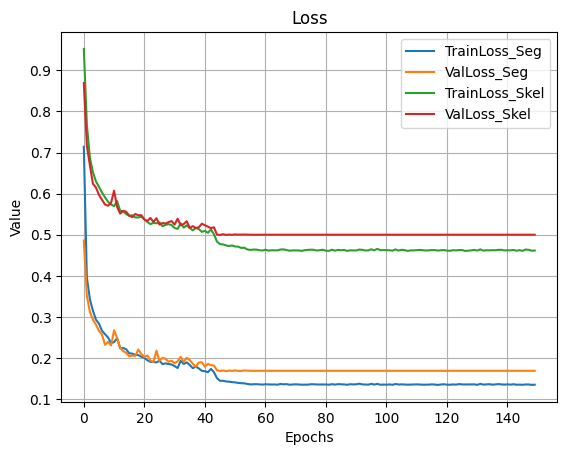

In [ ]:
# Convertir el historial en un DataFrame
df = pd.DataFrame(hist)
df2 = pd.DataFrame(hist2)
df3 = pd.DataFrame(hist3)
df4 = pd.DataFrame(hist4)
df5 = pd.DataFrame(hist5)
# Seleccionar solo las columnas de pérdida y IoU
columns_to_plot = [
    'TrainLoss_Seg','ValLoss_Seg',
    'TrainLoss_Skel', 'ValLoss_Skel'
]
df_plot = df[columns_to_plot]

# Graficar
df_plot.plot(grid=True)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')

cvs_pathfig = '/content/drive/MyDrive/Multitask/Histogramas/Loss_UnetMultiTask_16INIDLossAttention.png'
plt.savefig(cvs_pathfig, dpi=300, bbox_inches='tight')

plt.show()

csv_path =  '/content/drive/MyDrive/Multitask/Histogramas/hist1_UnetMultiTask_16INIDLossAttention.csv'
df.to_csv(csv_path, index=False)

csv_path = '/content/drive/MyDrive/Multitask/Histogramas/hist2_UnetMultiTask_16INIDLossAttention.csv'
df2.to_csv(csv_path, index=False)

csv_path =  '/content/drive/MyDrive/Multitask/Histogramas/hist3_UnetMultiTask_16INIDLossAttention.csv'
df3.to_csv(csv_path, index=False)

csv_path =  '/content/drive/MyDrive/Multitask/Histogramas/hist4_UnetMultiTask_16INIDLossAttention.csv'
df4.to_csv(csv_path, index=False)

csv_path =  '/content/drive/MyDrive/Multitask/Histogramas/hist5_UnetMultiTask_16INIDLossAttention.csv'
df5.to_csv(csv_path, index=False)


In [ ]:
def evaluate_test_model(model, test_loader):
    model.eval()  # Cambiar a modo de evaluación
    test_lossSeg, test_lossSkel = [], []
    test_iouSeg, test_iouSkel = [], []
    test_diceSeg, test_diceSkel = [], []
    test_hausSeg, test_hausSkel = [], []
    test_accSeg, test_accSkel = [], []
    test_precSeg, test_precSkel = [], []
    test_recallSeg, test_recallSkel = [], []
    test_f1Seg, test_f1Skel = [], []

    criterion = torch.nn.BCEWithLogitsLoss()
    all_pred_seg = []
    all_pred_skel = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Evaluando el modelo en el conjunto de test")
        for imgs, msks, skls in test_bar:
            imgs, msks, skls = imgs.to(device), msks.to(device), skls.to(device)
            predSeg, predSkel = model(imgs)

            # Pérdidas de segmentación y esqueleto
            lossSeg = criterion(predSeg, msks)
            lossSkel = criterion(predSkel, skls)

            # Calcular las métricas
            iouSeg, accSeg, precSeg, recallSeg, f1Seg, diceSeg = MetriX(predSeg, msks)
            iouSkel, accSkel, precSkel, recallSkel, f1Skel, diceSkel = MetriX(predSkel, skls)
            #hausSeg = Hausdorff_distance1(predSeg, msks)
            #hausSkel = Hausdorff_distance1(predSkel, skls)

            # Guardar los resultados
            test_lossSeg.append(lossSeg.item())
            test_lossSkel.append(lossSkel.item())
            test_iouSeg.append(iouSeg)
            test_diceSeg.append(diceSeg)
            test_iouSkel.append(iouSkel)
            test_diceSkel.append(diceSkel)
            test_accSeg.append(accSeg)
            test_accSkel.append(accSkel)
            test_precSeg.append(precSeg)
            test_precSkel.append(precSkel)
            test_recallSeg.append(recallSeg)
            test_recallSkel.append(recallSkel)
            test_f1Seg.append(f1Seg)
            test_f1Skel.append(f1Skel)
            # Calcular la distancia de Hausdorff para la tercera predicción de cada batch
            for i in range(predSeg.size(0)):  # i = índice de la predicción en el batch
                if i == 2:  # tercera predicción en el batch
                    hausdorff_seg = Hausdorff_distance1(predSeg[i], msks[i])
                    hausdorff_skel = Hausdorff_distance1(predSkel[i], skls[i])
                    test_hausSeg.append(hausdorff_seg)
                    test_hausSkel.append(hausdorff_skel)



            # Almacenar predicciones en listas
            all_pred_seg.append(torch.sigmoid(predSeg).cpu().detach())
            all_pred_skel.append(torch.sigmoid(predSkel).cpu().detach())


        # Guardar las predicciones de toda la época después de iterar sobre todos los batches
        for batch_idx in range(len(all_pred_seg)):
            for i in range(all_pred_seg[batch_idx].size(0)):
                pred_seg = all_pred_seg[batch_idx][i].squeeze().numpy()
                pred_skel = all_pred_skel[batch_idx][i].squeeze().numpy()

                file_path_seg = os.path.join(save_path3, f"PredictionTest_Seg_{batch_idx * batch_size + i}_UnetMultiTask_16INIDLossAttention.png")
                file_path_skel = os.path.join(save_path4, f"PredictionTest_Skel_{batch_idx * batch_size + i}_UnetMultiTask_16INIDLossAttention.png")
                plt.imsave(file_path_seg, pred_seg, cmap='gray')
                plt.imsave(file_path_skel, pred_skel, cmap='gray')


    # Imprimir resultados finales
    print("\nResultados de la evaluación en el conjunto de test:")
    print(f"Test Loss Seg: {np.mean(test_lossSeg):.5f}")
    print(f"Test Loss Skel: {np.mean(test_lossSkel):.5f}")
    print(f"Test IoU Seg: {np.mean(test_iouSeg):.5f}")
    print(f"Test IoU Skel: {np.mean(test_iouSkel):.5f}")
    print(f"Test Dice Seg: {np.mean(test_diceSeg):.5f}")
    print(f"Test Dice Skel: {np.mean(test_diceSkel):.5f}")
    print(f"Test Accuracy Seg: {np.mean(test_accSeg):.5f}")
    print(f"Test Accuracy Skel: {np.mean(test_accSkel):.5f}")
    print(f"Test Precision Seg: {np.mean(test_precSeg):.5f}")
    print(f"Test Precision Skel: {np.mean(test_precSkel):.5f}")
    print(f"Test Recall Seg: {np.mean(test_recallSeg):.5f}")
    print(f"Test Recall Skel: {np.mean(test_recallSkel):.5f}")
    print(f"Test F1 Score Seg: {np.mean(test_f1Seg):.5f}")
    print(f"Test F1 Score Skel: {np.mean(test_f1Skel):.5f}")
    print(f"Test Hausdorff Distance Seg: {np.mean(test_hausSeg):.5f}")
    print(f"Test Hausdorff Distance Skel: {np.mean(test_hausSkel):.5f}")

    # Retornar los resultados si deseas usarlos posteriormente
    return {
        "Test Loss Seg": np.mean(test_lossSeg),
        "Test Loss Skel": np.mean(test_lossSkel),
        "Test IoU Seg": np.mean(test_iouSeg),
        "Test IoU Skel": np.mean(test_iouSkel),
        "Test Dice Seg": np.mean(test_diceSeg),
        "Test Dice Skel": np.mean(test_diceSkel),
        "Test Accuracy Seg": np.mean(test_accSeg),
        "Test Accuracy Skel": np.mean(test_accSkel),
        "Test Precision Seg": np.mean(test_precSeg),
        "Test Precision Skel": np.mean(test_precSkel),
        "Test Recall Seg": np.mean(test_recallSeg),
        "Test Recall Skel": np.mean(test_recallSkel),
        "Test F1 Score Seg": np.mean(test_f1Seg),
        "Test F1 Score Skel": np.mean(test_f1Skel),
        "Test Hausdorff Distance Seg": np.mean(test_hausSeg),
        "Test Hausdorff Distance Skel": np.mean(test_hausSkel),
    }

In [ ]:
# Cargar el mejor modelo guardado
#best_model_path = os.path.join(save_path, 'best_model_UnetMultiTaskSimpleBasadaOriginal.pth')
# Cargar el mejor modelo guardado para evaluar en el conjunto de prueba
model.load_state_dict(torch.load(os.path.join(save_path, 'best_model_UnetMultiTask_16INIDLossAttention.pth')))
model = model.to(device)

# Evaluar el modelo en el conjunto de test
test_results = evaluate_test_model(model, test_loader)

# Si deseas guardar los resultados en un archivo CSV
#test_results_df = pd.DataFrame([test_results])
#test_results_csv_path = '/content/drive/MyDrive/Histogramas/prueba4/test_results_prueba5.csv'
#test_results_df.to_csv(test_results_csv_path, index=False)

<ipython-input-23-11d7d72d3ef7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_path, 'best_model_UnetMultiTask_16INIDLos


Resultados de la evaluación en el conjunto de test:
Test Loss Seg: 0.22418
Test Loss Skel: 0.09958
Test IoU Seg: 0.77335
Test IoU Skel: 0.40551
Test Dice Seg: 0.86954
Test Dice Skel: 0.57252
Test Accuracy Seg: 0.98518
Test Accuracy Skel: 0.99309
Test Precision Seg: 0.87302
Test Precision Skel: 0.55999
Test Recall Seg: 0.87634
Test Recall Skel: 0.60339
Test F1 Score Seg: 0.87393
Test F1 Score Skel: 0.58014
Test Hausdorff Distance Seg: 87.02019
Test Hausdorff Distance Skel: 85.43610
